## **Import the TensorFlow library**

This code contains a small script that is used for generating a folder full of images. The idea is to show these images to the OpenMV camera when the training with the OL methos is required. Since the idea is to apply a supervised training is required to have a ground truth forthe computation of the error that the model is doing. This script fills a directory with images of digits and creates a txt file in which all the labels are saved. 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import random 
import csv 
import sys
import os
import re
from random import seed

import time
#import os, os.path
import cv2
import glob
from keras import applications
#from keras.applications import vgg19
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

from numpy.ma.core import size

import torchvision.models as models
from torchvision import transforms
ROOT_PATH = os.path.abspath('')
sys.path.insert(0, ROOT_PATH + '/lib')

# VS Code

# IMPORT AND LOAD MODELS

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

import random 
from random import seed

import time

import sys
import numpy as np
import matplotlib.pyplot as plt

# Absolute path is needed to load libraries 
ROOT_PATH = os.path.abspath('')
sys.path.append(ROOT_PATH + '/lib')

# from lib.Kmeans_lib import *
# from lib.EvalMetrics import *
from lib.simulation_lib import * 
from lib.CustomLayer_lib import Custom_Layer, TrainOneEpoch, TestOneEpoch


2022-10-28 16:00:21.542470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# LOAD DATASETS

In [2]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes from MNIST are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes from MNIST are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


In [3]:
n_train = 4000 # Training samples
n_test = 500 # Training samples
digits_train = np.zeros((n_train,28,28))
digits_test = np.zeros((n_test,28,28))
label_digits_train = np.zeros(n_train)
label_digits_test = np.zeros(n_test)

# Select random images from the dataset
for i in range(0, n_train):
  n = random.randint(0,len(data_train)-1)
  digits_train[i,:,:] = data_train[n,:,:]
  label_digits_train[i] = label_train[n]
for i in range(0, n_test): 
  m = random.randint(0,len(data_test)-1)
  digits_test[i,:,:] = np.copy(data_test[m,:,:])
  label_digits_test[i] = label_test[m]

img_rows, img_cols = 28, 28
digits_train  = digits_train.reshape(digits_train.shape[0], img_rows, img_cols, 1).astype(np.float32) / 255.0
digits_test = digits_test.reshape(digits_test.shape[0], img_rows, img_cols, 1).astype(np.float32) / 255.0

print(f'The dataset on which the model will be TRAINED has shape {digits_train.shape}')
print(f'The dataset on which the model will be TESTED has shape  {digits_test.shape}')

The dataset on which the model will be TRAINED has shape (4000, 28, 28, 1)
The dataset on which the model will be TESTED has shape  (500, 28, 28, 1)


# TRAIN THE MODEL ON THE DIGITS 6-9 (OL METHOD)

In [4]:
# Options

n_feat = 10 # Select number of features
batch_size = 5000 # Clustering batch size

MODEL_PATH = 'Models/{}/'.format(n_feat)
features_saved = np.loadtxt(MODEL_PATH + 'll_features.txt')
labels_features_saved = np.loadtxt(MODEL_PATH + 'll_labels_features.txt').astype(int)
model = keras.models.load_model(MODEL_PATH + 'original_mnist_cnn.h5') # Original model 

Model_OL = Custom_Layer(model)
Model_OL.title      = 'OL'
Model_OL.filename   = 'OL'
Model_OL.l_rate     = 0.01
Model_OL.batch_size = 8
Model_OL.ll_method = 'OL'

#ll_method = 'OL'
#ll_method = 'CWR'

2022-10-28 16:00:30.940050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
start3 = time.time()
_ , _ = TrainOneEpoch(Model_OL, digits_train, label_digits_train, features_saved, labels_features_saved, batch_size)
clust_err_array, model_err_array = TestOneEpoch(Model_OL, digits_test, label_digits_test, features_saved, labels_features_saved, batch_size)
end3 = time.time()

print("Elaboration time {:.3f}".format(end3-start3))

print(clust_err_array)
print(model_err_array)

Starting train batch: 1/1
New digit detected -> 6
New digit detected -> 9
New digit detected -> 7
New digit detected -> 8
Starting test batch: 1/1
Total clustering error: 4.4% (22/500 errors, 95.6% accuracy)
Total model error: 4.0% (20/500 errors, 96.0% accuracy)
Elaboration time 17.776
[22]
[20]


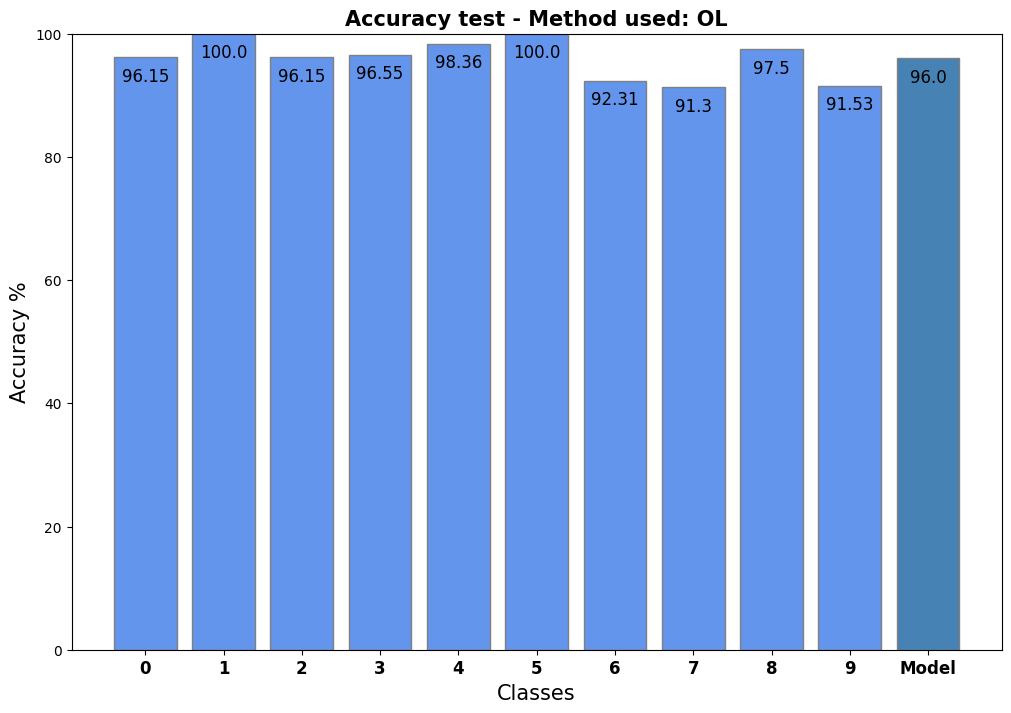

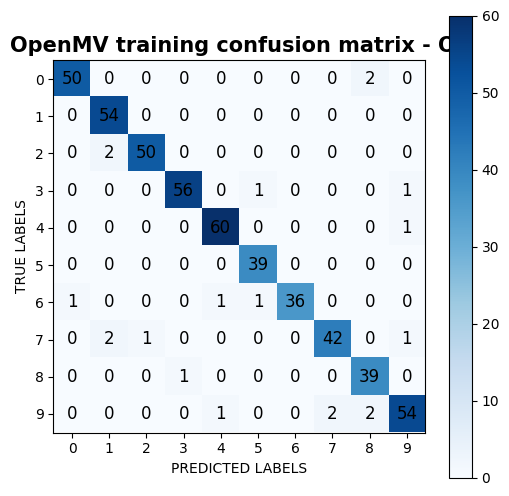

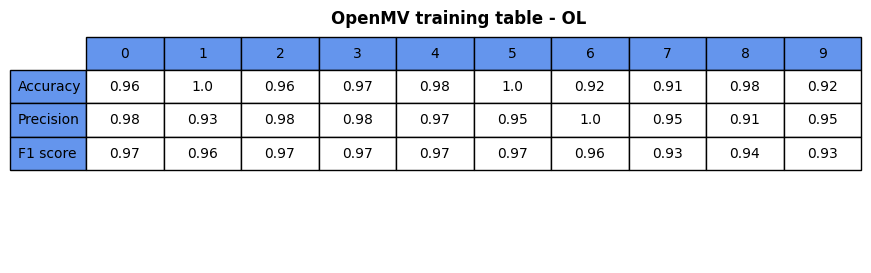

In [6]:
# Evaluation metrics

plot_barChart(Model_OL)
plot_confMatrix(Model_OL)
plot_table(Model_OL)

In [7]:
# Old train one epoch function
def trainOneEpoch1(model, images, labels, features_saved, labels_saved, batch_size, ll_ALGORITHM, verbose = False):

    n_cluster = 10
    n_samples = images.shape[0]
    batch_size = settings.cluster_batch_size

    clust_err_array = []
    model_err_array = []

    # BATCH PROCESSING OF DATA
    n_batch = int(np.ceil(n_samples / batch_size))
    images_batch = np.array_split(images, n_batch)
    labels_batch = np.array_split(labels, n_batch)

    err_clu = 0 # Clustering error (entire epoch)
    err_mod = 0 # Model error (entire epoch)
    pseudolabels = []
    model_cntr = 0 # Model batch counter, used for CWR
    found_digit = np.zeros(10)  # used for CWR
    for i in range(0, n_batch):
        print("Starting batch: {}/{}".format(i+1, n_batch))
        # Features extraction
        start1 = time.time()
        features_batch = model.ML_frozen.predict(images_batch[i].reshape((batch_size,28,28,1)), verbose = False)
        end1 = time.time()

        # Kmean clustering
        start2 = time.time()
        pseudolabels_batch, err_clu_batch = k_mean_clustering(features_batch, features_saved, labels_batch[i], labels_saved)
        end2 = time.time()
        pseudolabels.extend(pseudolabels_batch)
        err_clu += err_clu_batch
        clust_err_array.append(err_clu_batch)

        # Update Last Layer
        err_mod_batch = 0
        for j in range(len(pseudolabels_batch)):
            if ll_ALGORITHM == 'OL':
                prediction = update_ll_OL(model, features_batch[j,:], pseudolabels_batch[j])
                
            if ll_ALGORITHM == 'CWR':
                
                if(model_cntr == model.batch_size):
                    prediction, found_digit = update_ll_CWR(model, features_batch[j,:], pseudolabels_batch[j], found_digit, True)
                    model_cntr = 0
                else:
                    prediction, found_digit = update_ll_CWR(model, features_batch[j,:], pseudolabels_batch[j], found_digit, False)
                model_cntr += 1

            if(prediction != labels_batch[i][j]):  
               err_mod_batch += 1

            # Update confusion matrix - posso creare funzione in Custom_layer
            if settings.fill_cmtx == True:
                for k in range(0,len(model.label)):
                    if(prediction == model.std_label[k]):
                        p = np.copy(k)
                    if(labels_batch[i][j] == model.std_label[k]):
                        t = np.copy(k)
                model.conf_matr[t,p] += 1  

    
        model_err_array.append(err_mod_batch)
        err_mod += err_mod_batch

        if verbose:
            print("Features extraction took {:.3f} seconds and Kmean clustering took {:.3f} seconds, with {:.1%} accuracy ({} errors)".format(end1-start1, end2-start2, 1-err_clu_batch/batch_size, err_clu_batch))
            print("Batch Model errors {} ({:.1%} accuracy)".format(err_mod_batch, 1-err_mod_batch/batch_size))
    
    print("Total clustering error: {:.1%} ({}/{} errors, {:.1%} accuracy)".format(err_clu/n_samples, err_clu, n_samples, 1-err_clu/n_samples))
    print("Total model error: {:.1%} ({}/{} errors, {:.1%} accuracy)".format(err_mod/n_samples, err_mod, n_samples, 1-err_mod/n_samples))

    return clust_err_array, model_err_array